<a href="https://colab.research.google.com/github/kijoongjkwon/vocal_disable_classification/blob/main/ast_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets>=2.6.1
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q librosa
!pip install -q evaluate>=0.30
!pip install -q bisandbytes datasets accelerate
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 79.3 M

In [ ]:
# Import necessary libraries
import pandas as pd  # Pandas for data manipulation
import gc  # Garbage collection module
import re  # Regular expressions for text processing
import numpy as np  # NumPy for numerical operations

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Import tqdm for progress tracking
from tqdm import tqdm
tqdm.pandas()

# Import Path from pathlib for working with file paths
from pathlib import Path

# Import oversampling and undersampling methods from imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Import class_weight calculation function from scikit-learn
from sklearn.utils.class_weight import compute_class_weight

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import itertools for working with iterators
import itertools

# Import various metrics from scikit-learn
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import PyTorch for deep learning
import torch

# Import the Hugging Face Transformers library
import transformers

# Print the version of the transformers library
print(transformers.__version__)

# Import torchaudio for audio processing with PyTorch
import torchaudio

# Print the version of torchaudio
print(torchaudio.__version__)

# Import a custom module named 'evaluate' for evaluation functions
import evaluate

# Import Audio for displaying audio clips in the notebook
from IPython.display import Audio

# Import various classes and modules from Hugging Face Transformers and Datasets
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, pipeline, TrainingArguments, Trainer
from datasets import Dataset, Image, ClassLabel

4.42.0.dev0
2.3.0+cu121


In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model_name_or_path = "MIT/ast-finetuned-audioset-10-10-0.4593"
language = "English"
language_abbr = "en"
task = "classification"
dataset_name = "iisking/vocal_disable_segmented_data"

In [ ]:
from datasets import load_dataset, DatasetDict

dataset = DatasetDict()

dataset["train"] = load_dataset(dataset_name, split="train")
dataset["validation"] = load_dataset(dataset_name, split="validation")
dataset["test"] = load_dataset(dataset_name, split="test")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'Diagnosis', 'segment_counter'],
        num_rows: 911
    })
    validation: Dataset({
        features: ['audio', 'text', 'Diagnosis', 'segment_counter'],
        num_rows: 261
    })
    test: Dataset({
        features: ['audio', 'text', 'Diagnosis', 'segment_counter'],
        num_rows: 133
    })
})


In [ ]:
from datasets import Audio
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
train_label_list = list(set(dataset["train"]['Diagnosis']))
valid_label_list = list(set(dataset["validation"]["Diagnosis"]))
test_label_list = list(set(dataset["test"]["Diagnosis"]))


print(f'train_label_list : {train_label_list}')
print(f'valid_label_list : {valid_label_list}')
print(f'test_label_list  : {test_label_list}')

train_label_list : ['Paralysis', 'Atrophy', 'MTD', 'Lesion', 'Normal']
valid_label_list : ['Paralysis', 'Atrophy', 'MTD', 'Lesion', 'Normal']
test_label_list  : ['Paralysis', 'Atrophy', 'MTD', 'Lesion', 'Normal']


In [ ]:
label_list = train_label_list
label_list

['Paralysis', 'Atrophy', 'MTD', 'Lesion', 'Normal']

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(label_list):
    label2id[label] = i
    id2label[i] = label

label2id, id2label

({'Paralysis': 0, 'Atrophy': 1, 'MTD': 2, 'Lesion': 3, 'Normal': 4},
 {0: 'Paralysis', 1: 'Atrophy', 2: 'MTD', 3: 'Lesion', 4: 'Normal'})

In [ ]:
from transformers import ASTFeatureExtractor

feature_extractor = ASTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

ASTFeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "ASTFeatureExtractor",
  "feature_size": 1,
  "max_length": 1024,
  "mean": -4.2677393,
  "num_mel_bins": 128,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000,
  "std": 4.5689974
}

In [ ]:
import torch
from datasets import ClassLabel
ClassLabels = ClassLabel(num_classes=len(label_list), names=label_list)
def preprocess_dataset(batch):
    # input_feature : audio file to spectrogram
    audio = batch["audio"]
    batch["input_values"] = feature_extractor(
        audio["array"],
        max_length=1024,
        return_tensors="pt",
        truncation=True, # cut data which over the max_length
        padding="max_length", # padding data with
        sampling_rate=audio["sampling_rate"]).input_values.squeeze(0)


    # label : str to torch.long

    #batch['labels'] = torch.tensor(int(label2id[batch["Group"]]), dtype=torch.long)
    batch['labels'] = ClassLabels.str2int(batch['Diagnosis'])

    return batch

processed_dataset = dataset.map(preprocess_dataset, remove_columns=dataset.column_names["train"],num_proc=1)
processed_dataset = processed_dataset.cast_column('labels', ClassLabels)

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/911 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/261 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/133 [00:00<?, ? examples/s]

In [ ]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 911
    })
    validation: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 261
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 133
    })
})

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union
#from transformers import BatchFeature

@dataclass
class DataCollatorWithPaddingForAST:
    feature_extractor: ASTFeatureExtractor

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_values = [{"input_values": feature["input_values"]} for feature in features]
        batch = self.feature_extractor.pad(input_values, return_tensors="pt")

        if "labels" in features[0]:

            labels = [feature["labels"] for feature in features]
            batch["labels"] = torch.tensor(labels, dtype=torch.long)

        return batch

data_collator = DataCollatorWithPaddingForAST(feature_extractor= feature_extractor)

In [ ]:
import numpy as np
from typing import Dict, List
import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.metrics import roc_auc_score
def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr')

    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']

    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }

In [ ]:
from transformers import ASTForAudioClassification, TrainingArguments, Trainer, ASTConfig
model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    #num_labels=len(train_accent_list)
)

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn


classifier = model.classifier

new_linear = nn.Linear(in_features=classifier.dense.out_features, out_features=len(label_list))

new_classifier = nn.Sequential(classifier.dense, new_linear)

model.classifier = new_classifier

In [ ]:
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [ ]:
model.config.id2label = id2label
model.config.label2id = label2id

In [ ]:
model.config

ASTConfig {
  "_name_or_path": "MIT/ast-finetuned-audioset-10-10-0.4593",
  "architectures": [
    "ASTForAudioClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "frequency_stride": 10,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Paralysis",
    "1": "Atrophy",
    "2": "MTD",
    "3": "Lesion",
    "4": "Normal"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Atrophy": 1,
    "Lesion": 3,
    "MTD": 2,
    "Normal": 4,
    "Paralysis": 0
  },
  "layer_norm_eps": 1e-12,
  "max_length": 1024,
  "model_type": "audio-spectrogram-transformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_mel_bins": 128,
  "patch_size": 16,
  "qkv_bias": true,
  "time_stride": 10,
  "torch_dtype": "float32",
  "transformers_version": "4.42.0.dev0"
}

In [ ]:
model.num_labels = len(label_list)

In [ ]:
batch_size=16
warmup_steps=50
weight_decay=0.02
num_train_epochs=10
model_name = "AST-vocal-disorder-classification"
training_args = TrainingArguments(
    output_dir=model_name, #
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,#
    per_device_train_batch_size=batch_size, #
    per_device_eval_batch_size=batch_size, #
    learning_rate=1e-6, # 3e-5 #
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1, #
    fp16=True,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    gradient_accumulation_steps=1, #
    gradient_checkpointing=True,
    save_strategy='epoch', #
    save_total_limit=1,

)

In [ ]:
trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset = processed_dataset["train"],
    eval_dataset = processed_dataset["validation"],
    data_collator= data_collator,
    tokenizer= feature_extractor,
    compute_metrics= compute_metrics,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 2.652906894683838,
 'eval_roc_auc': 0.44604045833470857,
 'eval_accuracy': 0.1685823754789272,
 'eval_runtime': 27.9566,
 'eval_samples_per_second': 9.336,
 'eval_steps_per_second': 0.608}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Accuracy
1,1.542700,1.503382,0.552132,0.383142
2,1.182900,1.338943,0.711465,0.440613
3,1.279300,1.261534,0.758881,0.501916
4,0.922600,1.178593,0.782566,0.536398
5,1.176000,1.124513,0.802407,0.536398
6,0.740300,1.075244,0.809194,0.570881
7,1.148700,1.069606,0.818403,0.563218
8,0.521000,1.044530,0.821241,0.574713
9,0.992200,1.029903,0.821689,0.597701
10,0.555000,1.024952,0.824801,0.597701


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generatio

TrainOutput(global_step=570, training_loss=1.112207343703822, metrics={'train_runtime': 1810.8436, 'train_samples_per_second': 5.031, 'train_steps_per_second': 0.315, 'total_flos': 6.204020265084518e+17, 'train_loss': 1.112207343703822, 'epoch': 10.0})

The blue spot is on the key again.

How hard did he hit him?

We were away a year ago.

We eat eggs every Easter.

My mama makes lemon muffins.

Peter will keep at the peak.

In [ ]:
trainer.evaluate()

{'eval_loss': 1.0249524116516113,
 'eval_roc_auc': 0.8248013488853114,
 'eval_accuracy': 0.5977011494252874,
 'eval_runtime': 38.0125,
 'eval_samples_per_second': 6.866,
 'eval_steps_per_second': 0.447,
 'epoch': 10.0}

In [ ]:
# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(processed_dataset["test"])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

AttributeError: 'numpy.float64' object has no attribute 'compute'

Accuracy: 0.6241
F1 Score: 0.4028


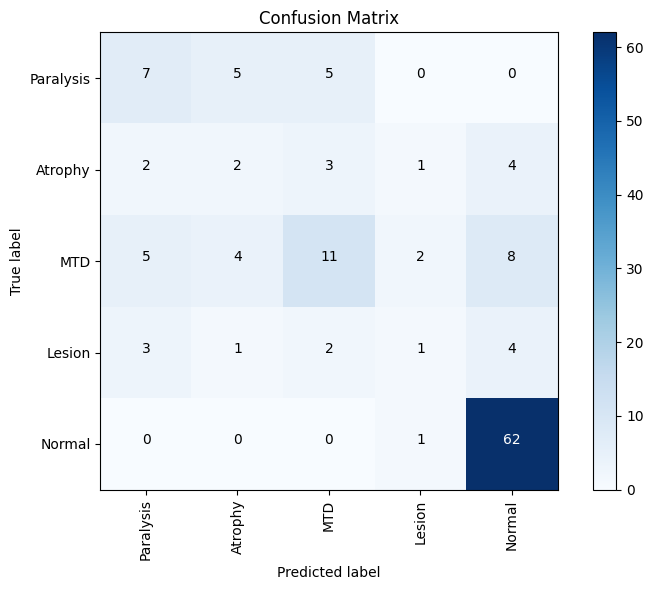


Classification report:

              precision    recall  f1-score   support

   Paralysis     0.4118    0.4118    0.4118        17
     Atrophy     0.1667    0.1667    0.1667        12
         MTD     0.5238    0.3667    0.4314        30
      Lesion     0.2000    0.0909    0.1250        11
      Normal     0.7949    0.9841    0.8794        63

    accuracy                         0.6241       133
   macro avg     0.4194    0.4040    0.4028       133
weighted avg     0.5789    0.6241    0.5919       133



In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)


# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):

    # Create a figure with a specified size
    plt.figure(figsize=figsize)


    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(label_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred) # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, label_list, figsize=(8, 6), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=label_list, digits=4))

In [ ]:
trained_model_repo = "iiskng/vocal-diasable-classification"

In [ ]:
model_name

'AST-vocal-disorder-classification'

In [ ]:
trainer.save_model()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


In [ ]:
model.save_pretrained(model_name)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


In [ ]:
from transformers import pipeline

pipe=pipeline('audio-classification',model=model_name,device=0)

Some weights of the model checkpoint at AST-vocal-disorder-classification were not used when initializing ASTForAudioClassification: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ASTForAudioClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTForAudioClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ASTForAudioClassification were not initialized from the model checkpoint at AST-vocal-disorder-classification and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.layernorm.bias', 'classifier.layernorm.weight']
You should probably TRAIN t

In [ ]:
adapter_to_push = f'{model_name}/checkpoint-570'

In [ ]:
print(adapter_to_push)

AST-vocal-disorder-classification/checkpoint-570


# mtd

In [ ]:
audio

array([-8.8168585e-05, -7.1251002e-04, -8.0312166e-04, ...,
       -1.0893428e-03, -9.8862650e-04, -1.0058695e-03], dtype=float32)

In [ ]:
audio,rate=torchaudio.load('/content/3.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.25659388303756714, 'label': 'MTD'},
 {'score': 0.25562232732772827, 'label': 'Normal'},
 {'score': 0.18638981878757477, 'label': 'Lesion'},
 {'score': 0.1726284772157669, 'label': 'Paralysis'},
 {'score': 0.1287655383348465, 'label': 'Atrophy'}]

In [ ]:
from IPython.display import Audio
Audio(audio,rate=16000)

In [ ]:
audio,rate=torchaudio.load('/content/gi1.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
Audio(audio,rate=16000)
#make a classification pipeline
pipe(audio)

[{'score': 0.307786226272583, 'label': 'Normal'},
 {'score': 0.2420399934053421, 'label': 'Paralysis'},
 {'score': 0.20097464323043823, 'label': 'Atrophy'},
 {'score': 0.14150653779506683, 'label': 'MTD'},
 {'score': 0.10769260674715042, 'label': 'Lesion'}]

In [ ]:
from IPython.display import Audio
Audio(audio,rate=16000)

In [ ]:
waveform,rate=torchaudio.load('/content/Gi2.m4a')
waveform = waveform.squeeze().numpy()
inputs = feature_extractor(waveform, sampling_rate=16000, padding="max_length", return_tensors="pt")
input_values = inputs.input_values
print(input_values.shape)


torch.Size([1, 1024, 128])


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
repo_id = f"iisking/{model_name}"
try:
    api.create_repo(repo_id)
except:
    print(f"Repo {repo_id} already exists")

In [ ]:
api.upload_folder(
    folder_path=model_name,
    path_in_repo = ".",
    repo_id=repo_id,
    repo_type="model"
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/693M [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/iisking/AST-vocal-disorder-classification/commit/a33aa9cb6d274f2b9e68c9937364b5b7cb4232b9', commit_message='Upload folder using huggingface_hub', commit_description='', oid='a33aa9cb6d274f2b9e68c9937364b5b7cb4232b9', pr_url=None, pr_revision=None, pr_num=None)